# **MRPA-LegNet**: Predicting gene expression from human massively parallel reporter assays with SOTA convolutional networks

This tutorial presents the use of MRPA-LegNet, a variant of LegNet ([Paper](https://doi.org/10.1093/bioinformatics/btad457),
[Repo](https://github.com/autosome-ru/LegNet/)) that was specifically modified and optimized for predicting gene expression from human massive parallel reporter assays performed with human K562, HepG2, and WTC11 cell lines.

Please don't hesitate to ask questions or share any feedback: dmitrypenzar1996@gmail.com

In order to train the model, a set of sequences with corresponding expression values is needed. We use MPRA data from the accompanying ZENODO repository [*link*] for the purposes of this tutorial.

In [29]:
from helper_functions import *

### The formal description of the problem

In contrast to the standard LegNet version ([Paper](https://doi.org/10.1093/bioinformatics/btad457),
[Repo](https://github.com/autosome-ru/LegNet/)), this version solves the problem of predicting gene expression from human massive parallel reporter assays in the classical setting, i.e. regression to single expression value, see Fig. 2b in [de Boer et al. (2020)](https://doi.org/10.1038/s41587-019-0315-8).

## Specify parameters

### 1. Data

The tab-separated training data must use the following format:

- First column: sequence. Second column: expression value. Third column: fold (optional).
- The data should be provided without any extra header line.


* ***model_dir*** - url of folder for all outputs;
* ***data_path*** - url of folder for input data;
* ***delimeter*** - delimeter between columns in training data files.

In [2]:
model_dir = Path('model')
data_path = Path('dataset')
delimiter = "\t"

train_path = data_path / 'WTC11_train.tsv'
valid_path = data_path / 'WTC11_valid.tsv'
test_path = data_path / 'WTC11_test.tsv'

The sequences are required to have equal lengths. We'll use both shift and reverse sequences augmentation. Shift augmentation requires a pre-defined surrounding plasmid sequence (forward and reverse sides). 

Specify length of sequences (*seqsize*) and maximum shift in both directions for data augmentation (*max_shift*, first element determines shift to the forward side, second - to the reverse side).

In [3]:
forward_side = "GGCCCGCTCTAGACCTGCAGG"
reverse_side = "CACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGT"
seqsize = 230 
max_shift = (len(forward_side),
             len(reverse_side))

### 2. Model Architecture

* ***in_ch*** - number of input channels for the model (one for each nucleotide, which adds up to 4, one additional for information on whether the original sequence was subjected to the reverse complementary transformation);
* ***stem_ch*** - number of output channels of the first (stem) block;
* ***stem_ks*** - kernel size of one-dimensional convolutional layer in the stem block;
* ***ef_ks*** - kernel size of convolutional layers in EfficientNet-like bloks;
* ***ef_block_sizes*** - list containing the number of channels for each EfficientNet-like block. The number of elements must be the same as in the next parameter;
* ***pool_sizes*** - list containing the parameters for 1D max pooling of each EfficientNet-like block. The number of elements must be the same as in the previous parameter;
* ***resize_factor*** - inverse of reduction parameter in squeeze-and-excitation blocks.

In [4]:
in_ch = 5
stem_ch = 64
stem_ks = 11
ef_ks = 9
ef_block_sizes = [80, 96, 112, 128]
pool_sizes = [2, 2, 2, 2]
resize_factor = 4


### 3 Model Training

#### Augmentation arguments
* ***reverse_augment*** - whether or not augment data with reverse complementary sequences;
* ***use_reverse_channel*** - whether or not add reverse augmentation channel. **Note, that this is not the same as reverse_augment**. The channel is usually supplied with either zeros (denoting forward) or ones (reverse complementary sequence);
* ***use_shift*** - whether or not augment data with shifted sequences (maximum possible degree of shift is defined in `max_shift` variable).

In [5]:
reverse_augment = True
use_reverse_channel = True
use_shift = True

#### Optimizer & Scheduler arguments
* ***max_lr*** - maximum learing rate during One Cycle Policy (OneCycleLR);
* ***weight_decay*** - weight decay coefficient for AdamW alghoritm;
* ***epoch_num*** - total number of epochs during training.

In [6]:
max_lr = 0.1
weight_decay = 0.1
epoch_num = 20

In [7]:
loss = nn.MSELoss()
train_batch_size = 1024
test_batch_size = 1024
weight_decay = 0.01
num_workers = 8

### Other arguments

In [8]:
device=1
seed = 777
set_global_seed(seed)
torch.set_float32_matmul_precision('medium')

## Data Preprocessing

### 1. Input vector structure
Training sequences were encoded into 4-dimensional vectors using one-hot encoding (`Seq2Tensor` class)


Since the regulatory elements are often asymmetric relative to the transcription start sites, **different scores are expected for direct and reverse complementary strands of a particular sequence**. Thus, the data can be augmented by providing each sequence twice in *native* and *reverse complementary form*, specifying `0` and `1`, respectively, in an additional `is_reverse` channel. The test-time augmentation can be performed by averaging the predictions made for direct (`is_reverse=0`) and reverse complementary (`is_reverse=1`) input.

![One hot encoding of input sequence](https://raw.githubusercontent.com/autosome-ru/LegNet/b0432ddead56e455b0d54ca798b5408dc496a8e7/tutorial/img/Input.jpg)

**Can I remove singleton channel and reuse this image?**

In [9]:
class Seq2Tensor(nn.Module):
    '''
    Encode sequences using one-hot encoding after preprocessing.
    '''
    def __init__(self):
        super().__init__()
    def forward(self, seq):
        if isinstance(seq, torch.FloatTensor):
            return seq
        seq = [n2id(x) for x in seq]
        code = torch.from_numpy(np.array(seq))
        code = F.one_hot(code, num_classes=5) # 5th class is N
        
        code[code[:, 4] == 1] = 0.25 # encode Ns with .25
        code = code[:, :4].float() 
        return code.transpose(0, 1)

### 2. Sequence Datasets
Trainer code uses [pytorch-lightning](https://github.com/Lightning-AI/pytorch-lightning) module.

Sequence datasets are implemented in `TrainSeqDatasetProb` and `TestSeqDatasetProb` classes. The difference between the two classes lies primarily in the **\_\_getitem\_\_** method (for selecting *i*-th sequence from the `pandas.DataFrame`). 

During training (`TrainSeqDatasetProb`), data can be augmented in two ways - by means of shift and reverse augmentations, where sequence shift is uniformly distributed in the boundaries defined by `maxshift`. 

In the second case (`TestSeqDatasetProb`) sequences can be constantly shifted and/or reversed (which is not data augmentation *per se*).

##### `TrainSeqDatasetProb`
**\_\_init\_\_** parameters:
- ***ds***: `pd.DataFrame` - Training dataset;
- ***use_shift***: `bool` - If True, additional shift augmentation is used;
- ***use_reverse***: `bool` - If True, additional reverse augmentation is used;
- ***use_reverse_channel***: `bool` - If True, extra channel indicating reversed sequences is added. **Note that this is not the same as *use_reverse***;
- ***seqsize***: `int` - Constant sequence length;
- ***maxshift***: `tuple[int, int]` - Maximum shift in both directions.

**\_\_getitem\_\_** output for `i`-th sequence (row) in the training dataset (`ds`):
- ***X***: `torch.Tensor` - One-hot encoding tensor (with reverse channel if required).
- ***bin***: `float` - Training expression value

In [10]:
class TrainSeqDatasetProb(Dataset):
    def __init__(self, 
                 ds: pd.DataFrame,
                 use_reverse: bool,
                 use_shift: bool,
                 use_reverse_channel: bool,  
                 seqsize=230,
                 max_shift: tuple[int, int] | None = None, 
                 training=True):
        self.training = training

        self.ds = ds
        self.totensor = Seq2Tensor() 
        self.use_reverse = use_reverse
        self.use_shift = use_shift
        self.use_reverse_channel = use_reverse_channel
        self.forward_side = forward_side
        self.reverse_side = reverse_side
        self.seqsize = seqsize 
        if max_shift is None:
            self.max_shift = (0, len(self.forward_side))
        else:
            self.max_shift = max_shift
        
            
    def transform(self, x):
        assert isinstance(x, str)
        return self.totensor(x)
    
    def __getitem__(self, i):

        seq = self.ds.seq.values[i]
        
        if self.use_shift:
            shift = torch.randint(size=(1,), low=-self.max_shift[0], high=self.max_shift[1] + 1).item()
            if shift < 0: # use forward primer
                seq = seq[:shift]
                seq = self.forward_side[shift:] + seq
            elif shift > 0:
                seq = seq[shift:]
                seq = seq + self.reverse_side[:shift]
            else: # shift = 0
                pass # nothing to do

        if self.use_reverse:
            r = torch.rand((1,)).item()
            if  r > 0.5:
                seq = reverse_complement(seq)
                rev = 1.0
            else:
                rev = 0.0
        else:
            rev = 0.0
            
        seq = self.transform(seq)
        to_concat = [seq]
        
        # add reverse augmentation channel
        if self.use_reverse_channel:
            rev = torch.full( (1, self.seqsize), rev, dtype=torch.float32)
            to_concat.append(rev)
            
        # create final tensor
        if len(to_concat) > 1:
            X = torch.concat(to_concat, dim=0)
        else:
            X = seq
            
        mean = self.ds.mean_value.values[i]
        
        return X, mean.astype(np.float32)
    
    def __len__(self):
        return len(self.ds.seq)

##### `TestSeqDatasetProb`
**\_\_init\_\_** parameters:
- ***ds***: `pd.DataFrame` - Test dataset;
- ***shift***: `int` - All sequences shifted by a constant value;
- ***reverse***: `bool` - If True, all sequences are reversed;
- ***use_reverse_channel***: `bool` - If True, extra channel indicating reversed sequences is added. **Note that this is not the same as *reverse***;
- ***seqsize***: `int` - Constant sequence length.

**\_\_getitem\_\_** output for `i`-th sequence (row) in the test dataset (`ds`):
- ***X***: `torch.Tensor` - One-hot encoding tensor (with reverse channel if required).
- ***bin***: `float` - Test expression value

In [11]:
class TestSeqDatasetProb(Dataset):
    def __init__(self, 
                 ds: pd.DataFrame,
                 reverse: bool,
                 shift: int,  
                 use_reverse_channel: bool = True,
                 seqsize=230):       
        self.ds = ds
        self.totensor = Seq2Tensor()
        self.use_reverse_channel = use_reverse_channel 
        self.reverse = reverse
        self.shift = shift
        self.forward_side = forward_side
        self.reverse_side = reverse_side
        self.seqsize = seqsize 

        
    def transform(self, x):
        assert isinstance(x, str)
        return self.totensor(x)
    
    def __getitem__(self, i):
        seq = self.ds.seq.values[i]
        
        if self.shift < 0: # use forward primer
            seq = seq[:self.shift]
            seq = self.forward_side[self.shift:] + seq
        elif self.shift > 0:
            seq = seq[self.shift:]
            seq = seq + self.reverse_side[:self.shift]
        else: # shift = 0
            pass # nothing to do

        
        if self.reverse:
            seq = reverse_complement(seq)
            rev = 1.0
        else:
            rev = 0.0

        seq = self.transform(seq)
        to_concat = [seq]
        
        # add reverse augmentation channel
        if self.use_reverse_channel:
            rev = torch.full( (1, self.seqsize), rev, dtype=torch.float32)
            to_concat.append(rev)
            
        # create final tensor
        if len(to_concat) > 1:
            X = torch.concat(to_concat, dim=0)
        else:
            X = seq
            
        mean = self.ds.mean_value.values[i]
        
        return X, mean.astype(np.float32)
    
    def __len__(self):
        return len(self.ds.seq)

### 3. Lightning Datamodule
`SeqDataModule` inherits `lightning.pytorch.LightningDataModule`. This class loads test and train datasets for **pytorch-lightning** module. 
Note, that in *dataset.py* file from the source code this class splits unified file into train, validation and test datasets based on values in the `fold_num` column, whilst pre-splitted files are used in this tutorial.

`SeqDataModule` passes ***reverse_augment***, ***use_reverse_channel***, ***use_shift***, ***max_shift*** parameters to the `TrainSeqDatasetProb` and `TestSeqDatasetProb` classes and ***train_batch_size***, ***test_batch_size***, ***num_workers*** parameters to the `torch.utils.data.DataLoader` class.

- **train_dataloader** creates training DataLoader for `trainer.fit()`;
- **val_dataloader** creates validation DataLoader for `trainer.fit()`. Based on highest Pearson coefficient between predicted and true validation expression values best-performing model across all epochs will be selected;
- **dls_for_predictions** creates test DataLoader (with reverse sequences, if required) for `trainer.predict()`.

In [12]:
class SeqDataModule(pl.LightningDataModule):
    def __init__(self, 
                 train_path: str,
                 valid_path: str,
                 test_path: str):
        super().__init__()
        
        ds_columns = ['seq', 'mean_value']
        self.train = pd.read_csv(train_path, sep='\t')
        self.valid = pd.read_csv(valid_path, sep='\t')
        self.test = pd.read_csv(test_path, sep='\t')
        self.train.columns = ds_columns
        self.valid.columns = ds_columns
        self.test.columns = ds_columns
        
        
    def train_dataloader(self):
        train_ds =  TrainSeqDatasetProb(self.train,
                                   use_reverse=reverse_augment,
                                   use_reverse_channel=use_reverse_channel,
                                   use_shift=use_shift,
                                   max_shift=max_shift)
        
        return DataLoader(train_ds, 
                          batch_size=train_batch_size,
                          num_workers=num_workers,
                          shuffle=True) 
    
    def val_dataloader(self): # test dataset
        valid_ds = TestSeqDatasetProb(self.valid, 
                                  use_reverse_channel=use_reverse_channel,
                                  shift=0,
                                  reverse=False)

        return DataLoader(valid_ds, 
                          batch_size=train_batch_size,
                          num_workers=num_workers,
                          shuffle=False)
        
    def dls_for_predictions(self): #
        
        test_ds = TestSeqDatasetProb(self.test,
                                  use_reverse_channel=use_reverse_channel,
                                  shift=0,
                                  reverse=False)
        test_dl =  DataLoader(test_ds,
                              batch_size=test_batch_size,
                              num_workers=num_workers,
                              shuffle=False)
        yield "forw_pred", test_dl
        if reverse_augment:
            rev_test_ds = TestSeqDatasetProb(self.test,
                                  use_reverse_channel=use_reverse_channel,
                                  shift=0,
                                  reverse=True)
            rev_test_dl =  DataLoader(rev_test_ds,
                              batch_size=test_batch_size,
                              num_workers=num_workers,
                              shuffle=False)
            yield "rev_pred", rev_test_dl

## Model architecture
Our model is based upon a fully-convolutional neural network architecture inspired by EfficientNetV2 with selected features from DenseNet and additional custom blocks.

![LegNet architecture](https://raw.githubusercontent.com/autosome-ru/LegNet/b0432ddead56e455b0d54ca798b5408dc496a8e7/tutorial/img/A.jpg)

In [13]:
class SELayer(nn.Module):
    def __init__(self, inp, reduction=4):
        super(SELayer, self).__init__()
        self.fc = nn.Sequential(
                nn.Linear(inp, int(inp // reduction)),
                nn.SiLU(),
                nn.Linear(int(inp // reduction), inp),
                nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, = x.size()
        y = x.view(b, c, -1).mean(dim=2)
        y = self.fc(y).view(b, c, 1)
        return x * y

In [14]:
class EffBlock(nn.Module):
    def __init__(self, in_ch, ks, resize_factor, activation, out_ch=None, se_reduction=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.resize_factor = resize_factor
        self.se_reduction = resize_factor if se_reduction is None else se_reduction
        self.ks = ks
        self.inner_dim = self.in_ch * self.resize_factor
        
        block = nn.Sequential(
                        nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.inner_dim,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.inner_dim,
                            kernel_size=ks,
                            groups=self.inner_dim,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.inner_dim),
                       activation(),
                       SELayer(self.inner_dim, reduction=self.se_reduction),
                       nn.Conv1d(
                            in_channels=self.inner_dim,
                            out_channels=self.in_ch,
                            kernel_size=1,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.in_ch),
                       activation(),
        )
        
        self.block = block
    
    def forward(self, x):
        return self.block(x)

In [15]:
class LocalBlock(nn.Module):
    def __init__(self, in_ch, ks, activation, out_ch=None):
        super().__init__()
        self.in_ch = in_ch
        self.out_ch = self.in_ch if out_ch is None else out_ch
        self.ks = ks
        
        self.block = nn.Sequential(
                       nn.Conv1d(
                            in_channels=self.in_ch,
                            out_channels=self.out_ch,
                            kernel_size=self.ks,
                            padding='same',
                            bias=False
                       ),
                       nn.BatchNorm1d(self.out_ch),
                       activation()
        )
        
    def forward(self, x):
        return self.block(x)


In [16]:
class ResidualConcat(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return torch.concat([self.fn(x, **kwargs), x], dim=1)

In [17]:
class MapperBlock(nn.Module):
    def __init__(self, in_features, out_features, activation=nn.SiLU):
        super().__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(in_features),
            nn.Conv1d(in_channels=in_features,
                      out_channels=out_features, 
                      kernel_size=1),
        )
        
    def forward(self, x):
        return self.block(x) 

In [18]:
class LegNet(nn.Module):
    def __init__(self, 
                 in_ch,
                 stem_ch,
                 stem_ks, 
                 ef_ks,
                 ef_block_sizes,
                 pool_sizes,
                 resize_factor,
                 activation=nn.SiLU,
                 ):
        super().__init__()
        assert len(pool_sizes) == len(ef_block_sizes)
        
        self.in_ch = in_ch
        self.stem = LocalBlock(in_ch=in_ch, 
                               out_ch=stem_ch,
                               ks=stem_ks,
                               activation=activation)
        
        blocks = []
       
        in_ch = stem_ch
        out_ch = stem_ch
        for pool_sz, out_ch in zip(pool_sizes, ef_block_sizes):
            blc = nn.Sequential(
                ResidualConcat(
                    EffBlock(
                        in_ch=in_ch, 
                        out_ch=in_ch,
                        ks=ef_ks,
                        resize_factor=resize_factor,
                        activation=activation)
                ),
                LocalBlock(in_ch=in_ch * 2,
                           out_ch=out_ch,
                           ks=ef_ks,
                           activation=activation),
                nn.MaxPool1d(pool_sz) if pool_sz != 1 else nn.Identity()
            )
            in_ch = out_ch
            blocks.append(blc)
        self.main = nn.Sequential(*blocks)
        
        self.mapper = MapperBlock(in_features=out_ch, 
                                  out_features=out_ch * 2)
        self.head = nn.Sequential(nn.Linear(out_ch * 2, out_ch * 2),
                                   nn.BatchNorm1d(out_ch * 2),
                                   activation(),
                                   nn.Linear(out_ch * 2, 1))
            
    def forward(self, x):
        x = self.stem(x)
        x = self.main(x)
        x = self.mapper(x)
        x =  F.adaptive_avg_pool1d(x, 1)
        x = x.squeeze(-1)
        x = self.head(x)
        x = x.squeeze(-1)
        return x

### 4. Trainer
The trainer is `LitModel` class, which inherits `lightning.pytorch.LightningModule`.
Here we instantiate our model, initialize it's weights and pass loss function and metric for validation (`PearsonCorrCoef`).

Also we define training, validation, test and predict steps for pl.LightningModule

In [19]:
class LitModel(pl.LightningModule):
    def __init__(self, max_lr):
        super().__init__()
        
        self.model = LegNet(in_ch=in_ch,
                            stem_ch=stem_ch,
                            stem_ks=stem_ks,
                            ef_ks=ef_ks,
                            ef_block_sizes=ef_block_sizes,  
                            resize_factor=resize_factor,
                            pool_sizes=pool_sizes)
        self.model.apply(initialize_weights)
        self.loss = loss
        self.val_pearson = PearsonCorrCoef()
        self.max_lr = max_lr
        
    def training_step(self, batch, _):
        X, y = batch
        y_hat = self.model(X)

        loss = self.loss(y_hat, y)
        
        self.log("train_loss", loss, prog_bar=True,  on_step=False, on_epoch=True,  logger=True)
        return loss
    
    def validation_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.val_pearson(y_hat, y)
        self.log("val_pearson", self.val_pearson, on_epoch=True)
    
    def test_step(self, batch, _):
        x, y = batch
        y_hat = self.model(x)
        loss = self.loss(y_hat, y)
        self.log('test_loss', 
                 loss, 
                 prog_bar=True, 
                 on_step=False,
                 on_epoch=True)
        
    def predict_step(self, batch, _):
        if isinstance(batch, (tuple, list)):
            x, _ = batch 
        else:
            x = batch
        y_hat = self.model(x)
        return y_hat
        
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), 
                                      lr=self.max_lr  / 25,
                                      weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, # type: ignore
                                                        max_lr=self.max_lr ,
                                                        three_phase=False, 
                                                        total_steps=self.trainer.estimated_stepping_batches, # type: ignore
                                                        pct_start=0.3,
                                                        cycle_momentum =False)
        
        lr_scheduler_config = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "step",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # If using the `LearningRateMonitor` callback to monitor the
            # learning rate progress, this keyword can be used to specify
            # a custom logged name
            "name": "cycle_lr"
        }
        return [optimizer], [lr_scheduler_config]

## LR Finder
Here we'll define optimum learning rate value for model training.

Pass `pl.Trainer` instance to `pl.tuner.Tuner`, then run `Tuner.lr_find` on train data.

Parameter count:  tensor(1323169)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/nikgr/miniconda3/envs/legnet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
Loading `train_dataloader` to estimate number of stepping batches.


Estimated stepping batches -1


/home/nikgr/miniconda3/envs/legnet/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:70: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/home/nikgr/miniconda3/envs/legnet/lib/python3.11/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/home/nikgr/miniconda3/envs/legnet/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at model/model/.lr_find_5a35a765-65c3-4eae-a4ba-c4ebebec5f0d.ckpt
Restored all states from the checkpoint at model/model/.lr_find_5a35a765-65c3-4eae-a4ba-c4ebebec5f0d.ckpt


Suggested lr: 0.0013182567385564075


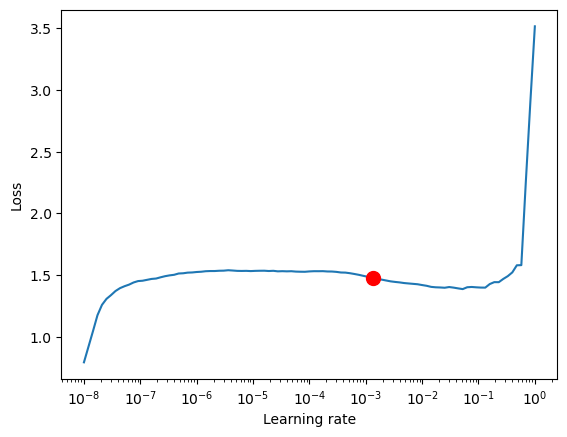

In [20]:
model = LitModel(max_lr)
print('Parameter count: ', parameter_count(model))

# Create Sequence DataModule and specifically train DataLoader
data = SeqDataModule(train_path=train_path,
                     valid_path=valid_path,
                     test_path=test_path)

train_dl = data.train_dataloader()

# Create Trainer, pass selected gpu device
dump_dir = model_dir / "model"
trainer = pl.Trainer(accelerator='gpu',
                     devices=[device], 
                     precision='16-mixed',
                     gradient_clip_val=1,
                     default_root_dir=dump_dir)

# Create pl.tuner.Tuner instance
tuner = pl.tuner.Tuner(trainer)

# Run learning rate finder
lr_finder = tuner.lr_find(model,
                          train_dataloaders=train_dl,
                          attr_name='max_lr')

# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print(f'Suggested lr: {new_lr:.6f}')

## Train Model
Here we'll train LegNet model with optimal learning rate (which was found on previous step by LR Finder).

In [21]:
model = LitModel(new_lr)
print("Model parameters: ", parameter_count(model).item())

# Create train & test DataLoaders
train_dl = data.train_dataloader()
valid_dl = data.val_dataloader()

# Setup model checkpoints for the model from the last epoch and for the best (in terms of pearson correlation on validation split) model
dump_dir = model_dir / f"model"
last_checkpoint_callback = pl.callbacks.ModelCheckpoint(   #type: ignore
    save_top_k=1,
    monitor="step",
    mode="max",
    filename="last_model-{epoch}",
    save_on_train_epoch_end=True,
)
        
best_checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    monitor="val_pearson",
    mode="max",
    filename="pearson-{epoch:02d}-{val_pearson:.2f}",
)

# Create Trainer, pass callbacks and desired number of epochs
trainer = pl.Trainer(accelerator='gpu',
                     enable_checkpointing=True,
                     devices=[device], 
                     precision='16-mixed', 
                     max_epochs=epoch_num,
                     callbacks=[last_checkpoint_callback,  best_checkpoint_callback],
                     gradient_clip_val=1,
                     default_root_dir=dump_dir)

# Train model
trainer.fit(model, 
    datamodule=data)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loading `train_dataloader` to estimate number of stepping batches.


Model parameters:  1323169



  | Name        | Type            | Params
------------------------------------------------
0 | model       | LegNet          | 1.3 M 
1 | loss        | MSELoss         | 0     
2 | val_pearson | PearsonCorrCoef | 0     
------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.293     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/home/nikgr/miniconda3/envs/legnet/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


TypeError: LitModel.__init__() missing 1 required positional argument: 'max_lr'

## Test Model
Here is code for predictions generation.

In [32]:
# Load best model and test it (create prediction for test data)
model = LitModel.load_from_checkpoint(best_checkpoint_callback.best_model_path, max_lr=new_lr)
df_pred = save_predict(trainer, 
                       model, 
                       data,
                       save_dir=dump_dir)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]